In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

In [2]:
import tensorflow as tf

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0


In [4]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


Number of original training examples: 60000
Number of original test examples: 10000


In [5]:
# Filter the dataset to keep just the 3s and 6s, remove the other classes. 
# At the same time convert the label, y, to boolean: True for 3 and False for 6. 
def filter_10(x, y):
    keep = (y == 1) | (y == 0)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

In [6]:
x_train, y_train = filter_10(x_train, y_train)
x_test, y_test = filter_10(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12665
Number of filtered test examples: 2115


True


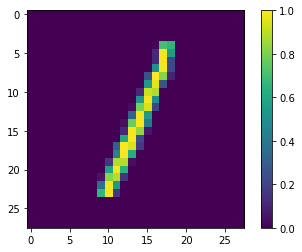

In [7]:
print(y_train[300])

plt.imshow(x_train[344, :, :, 0])
plt.colorbar()


In [8]:
n_small=7
x_train_small = tf.image.resize(x_train, (n_small,n_small)).numpy()
x_test_small = tf.image.resize(x_test, (n_small,n_small)).numpy()


In [9]:
x_train_small.shape

(12665, 7, 7, 1)

False


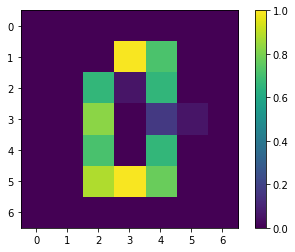

In [10]:
index=int(np.random.rand(1)*100)
#index=10
plt.imshow(x_train_small[index,:,:,0], vmin=0, vmax=1)
plt.colorbar()
print(y_train[index])

In [11]:
def dataAugmentation(data):
    #centering
    meanValues=data[None,:].mean(axis=1)
    data=data-meanValues[:,None]
    
    #scaling
    norm=np.linalg.norm(data,axis=2)
    scale=norm.max(axis=1)
    data=data/scale[:,None,None]
    
    return data



def prepareData(x,y,N_points,pixel_min=0.8):
    output_x=[]
    output_y=[]
    for index in range(x.shape[0]):
        p_list=[]
        pixel_list=[]
        for i in range(x_train_small[index,:,:,0].shape[0]):
            for j in range(x_train_small[index,:,:,0].shape[1]):
                pixel = x_train_small[index,i,j,0]
                if pixel>pixel_min:
                    p_list.append(np.array([i,j]))
                    pixel_list.append(x_train_small[index,i,j,0])
        p_list=np.array(p_list)
        pixel_list=np.array(pixel_list) 
        #print(y[index],p_list.shape[0])
        if p_list.shape[0]<N_points:
            continue
        r_ind=np.random.choice(np.arange(0,p_list.shape[0],1),N_points,replace=False)
        r_ind.sort()
        p_list=p_list[r_ind]
        p_aug=dataAugmentation(p_list)[0]
        
        
        output_x.append(p_aug)
        output_y.append(y[index])
        
    return np.array(output_x),np.array(output_y)
        

In [12]:
def plotPoints(p_list):
    for i in range(p_list.shape[0]):
        plt.scatter(p_list[i][0],p_list[i][1],color='black',s=50)

In [13]:
N=5
X_train_noDot,finalY_train=prepareData(x_train_small,y_train,N,pixel_min=0.4)
X_test_noDot,finalY_test=prepareData(x_test_small,y_train,N,pixel_min=0.4)



In [14]:
def Dot(data):
    output=[]
    for i in range(data.shape[0]):
        event=[]
        for j in range(data.shape[1]):
            for k in np.arange(j+1,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))

    
    output=np.array(output)
    return output

False


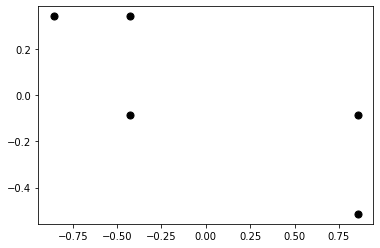

In [15]:
index=int(np.random.rand(1)*1000)
plotPoints(X_train_noDot[index])
print(finalY_train[index])

In [16]:
train_dot=Dot(X_train_noDot)
test_dot=Dot(X_test_noDot)

In [17]:
finalY_train.sum()/finalY_train.shape[0]

0.3856948371557231

In [18]:
finalY_test.sum()/finalY_test.shape[0]

0.4007285974499089

In [21]:
num_qubits=3

print(2**num_qubits-N*(N-1)/2 )

-2.0


In [22]:
N*(N-1)/2 

10.0

In [23]:

train_dot=train_dot[:,0:2**num_qubits]
test_dot=test_dot[:,0:2**num_qubits]

In [24]:
test_dot.shape

(1647, 8)

In [25]:
sampler = Sampler()



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    


In [26]:
# from qiskit_algorithms.optimizers import GradientDescent
# optimizer = COBYLA(maxiter=250)



In [27]:
# vqc = VQC(
#     sampler=sampler,
#     feature_map=RawFeatureVector(2**num_qubits),
#     #ansatz=EfficientSU2(num_qubits, reps=2),
#     ansatz=RealAmplitudes(num_qubits, reps=5),
#     optimizer=optimizer,
#     callback=callback_graph,
# )

In [28]:
# maxEvents=500

# # clear objective value history
# objective_func_vals = []

# start = time.time(a)
# vqc.fit(train_dot[0:maxEvents], y_train[0:maxEvents])
# elapsed = time.time() - start

In [29]:
vqc.score(train_dot[0:maxEvents],y_train[0:maxEvents])

NameError: name 'vqc' is not defined

In [30]:
vqc.score(train_dot[maxEvents:2*maxEvents],y_train[maxEvents:2*maxEvents])

NameError: name 'vqc' is not defined

In [ ]:
y_p=vqc.predict(train_dot[maxEvents:2*maxEvents])
                

In [ ]:
(1-y_train[maxEvents:2*maxEvents]).sum()/y_train[maxEvents:2*maxEvents].shape[0]

In [ ]:
(1-y_train[0:maxEvents]).sum()/y_train[maxEvents:2*maxEvents].shape[0]

In [31]:
num_qubits=train_dot.shape[1]
nLayer=3

In [34]:
maxIteration=400
maxEvents=200

In [35]:


sampler = Sampler()

feature_map_augDot = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
optimizer_augDot = COBYLA(maxiter=maxIteration)


vqc_augDot = VQC(
    sampler=sampler,
    feature_map=feature_map_augDot,
    ansatz=RealAmplitudes(num_qubits, reps=nLayer),
    optimizer=optimizer_augDot,
    callback=callback_graph,
)

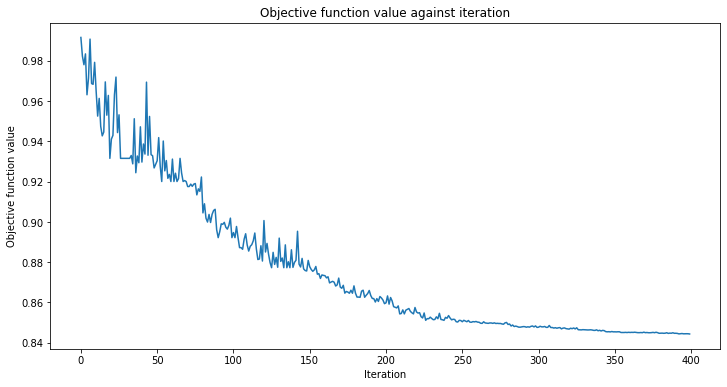

In [36]:


# clear objective value history
objective_func_vals = []

start = time.time()
vqc_augDot.fit(train_dot[0:maxEvents], finalY_train[0:maxEvents])
elapsed = time.time() - start

In [37]:
vqc_augDot.score(train_dot[0:maxEvents],finalY_train[0:maxEvents])

0.79

In [38]:
vqc_augDot.score(test_dot[0:maxEvents],finalY_test[0:maxEvents])

0.73

In [39]:
finalY_test[0:100].sum()/finalY_test[0:100].shape[0]

0.46